In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-09-20 04:53:19--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 13.35.7.93, 13.35.7.124, 13.35.7.12, ...
Connecting to segment-anything.com (segment-anything.com)|13.35.7.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K   361KB/s    in 0.6s    

2024-09-20 04:53:20 (361 KB/s) - ‘dog.jpg’ saved [221810/221810]



In [ ]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


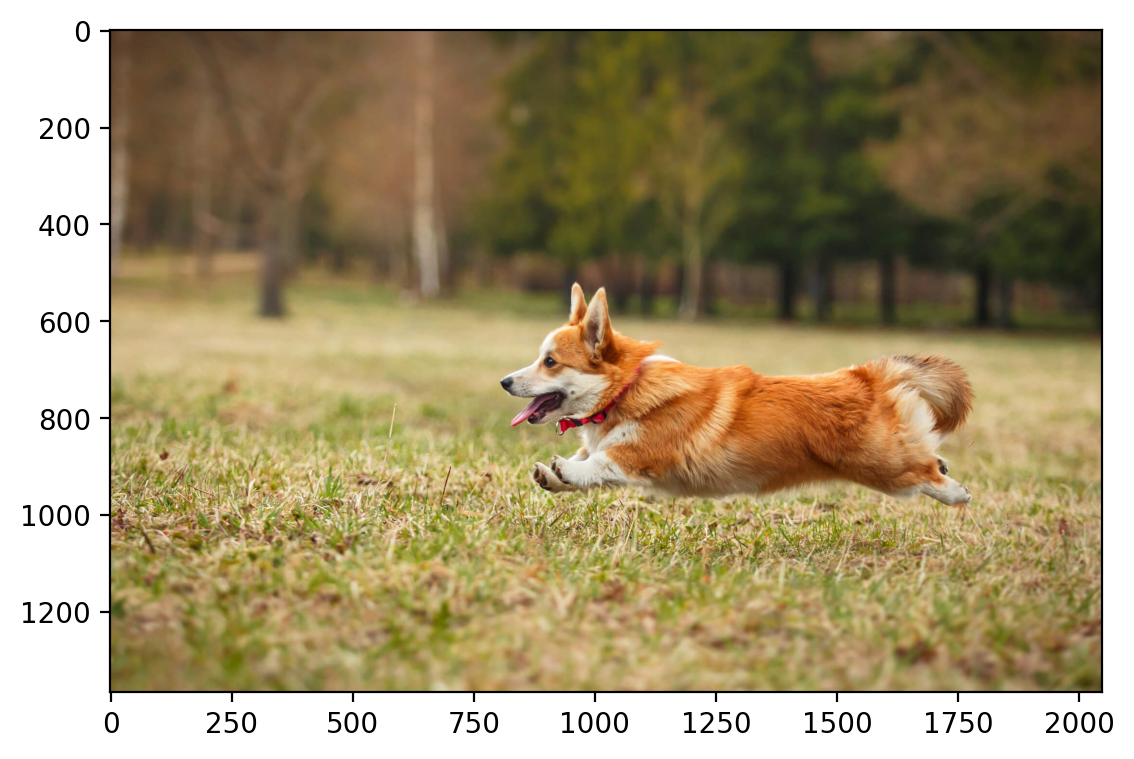

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:

from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [ ]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
print(crop.shape)
crop.to(device)

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5608, 0.5608, 0.5608],
         [0.7725, 0.7725, 0.7725,  ..., 0.5608, 0.5608, 0.5608],
         [0.7765, 0.7765, 0.7765,  ..., 0.5569, 0.5569, 0.5569],
         ...,
         [0.6196, 0.6353, 0.6353,  ..., 0.6431, 0.6471, 0.6549],
         [0.6157, 0.6706, 0.7216,  ..., 0.6824, 0.7059, 0.7216],
         [0.6353, 0.6902, 0.7294,  ..., 0.7137, 0.7490, 0.7725]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.4706, 0.4706, 0.4706],
         [0.6980, 0.6980, 0.6980,  ..., 0.4706, 0.4706, 0.4706],
         [0.7020, 0.7020, 0.7020,  ..., 0.4784, 0.4784, 0.4784],
         ...,
         [0.5176, 0.5333, 0.5255,  ..., 0.4431, 0.4353, 0.4314],
         [0.5333, 0.5922, 0.6353,  ..., 0.5020, 0.5137, 0.5176],
         [0.5647, 0.6196, 0.6549,  ..., 0.5529, 0.5686, 0.5843]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3373, 0.3373, 0.3373],
         [0.4784, 0.4784, 0.4784,  ..., 0.3373, 0.3373, 0.3373],
         [0.4824, 0.4824, 0.4824,  ..., 0.3412, 0.3412, 0.

In [ ]:
crop_=crop.cpu().detach().numpy()

In [ ]:
crop_

array([[[0.76862745, 0.76862745, 0.76862745, ..., 0.56078431,
         0.56078431, 0.56078431],
        [0.77254902, 0.77254902, 0.77254902, ..., 0.56078431,
         0.56078431, 0.56078431],
        [0.77647059, 0.77647059, 0.77647059, ..., 0.55686275,
         0.55686275, 0.55686275],
        ...,
        [0.61960784, 0.63529412, 0.63529412, ..., 0.64313725,
         0.64705882, 0.65490196],
        [0.61568627, 0.67058824, 0.72156863, ..., 0.68235294,
         0.70588235, 0.72156863],
        [0.63529412, 0.69019608, 0.72941176, ..., 0.71372549,
         0.74901961, 0.77254902]],

       [[0.69411765, 0.69411765, 0.69411765, ..., 0.47058824,
         0.47058824, 0.47058824],
        [0.69803922, 0.69803922, 0.69803922, ..., 0.47058824,
         0.47058824, 0.47058824],
        [0.70196078, 0.70196078, 0.70196078, ..., 0.47843137,
         0.47843137, 0.47843137],
        ...,
        [0.51764706, 0.53333333, 0.5254902 , ..., 0.44313725,
         0.43529412, 0.43137255],
        [0.5

In [ ]:
from sklearn.linear_model import LinearRegression
def upscale(image):
    height, width = image.shape[1:]
    upscaled_height = height * 2
    upscaled_width = width * 2
    print("height: ",height)
    print("width: ",width)
    upscaled_image = np.zeros((3, upscaled_height, upscaled_width),dtype=float)
    for i in range(0, height, 2):
        for j in range(0, width, 2):
            # Extract 2x2 block
            block = image[:, i:i+2, j:j+2]
            block1=block[0].reshape(1,-1)
            block2=block[1].reshape(1,-1)
            block3=block[2].reshape(1,-1)
            block_=np.vstack((block1,block2,block3)).T
            # Reshape block for linear regression
            X = np.array([[i, j], [i+1, j], [i, j+1], [i+1, j+1]],dtype=float)

            model = LinearRegression()
            model.fit(X, block_)
            X_new = np.array([[x, y] for x in np.linspace(i,i+1,4) for y in np.linspace(j,j+1,4)])
            interpolated_block = model.predict(X_new)
            interpolated_block1=interpolated_block[:,0].reshape(4,4)
            interpolated_block2=interpolated_block[:,1].reshape(4,4)
            interpolated_block3=interpolated_block[:,2].reshape(4,4)
            interpolated_block_=np.stack((interpolated_block1,interpolated_block2,interpolated_block3),axis=0)
            upscaled_image[:,2*i:2*i+4,2*j:2*j+4]=interpolated_block_
    return upscaled_image


height:  400
width:  400


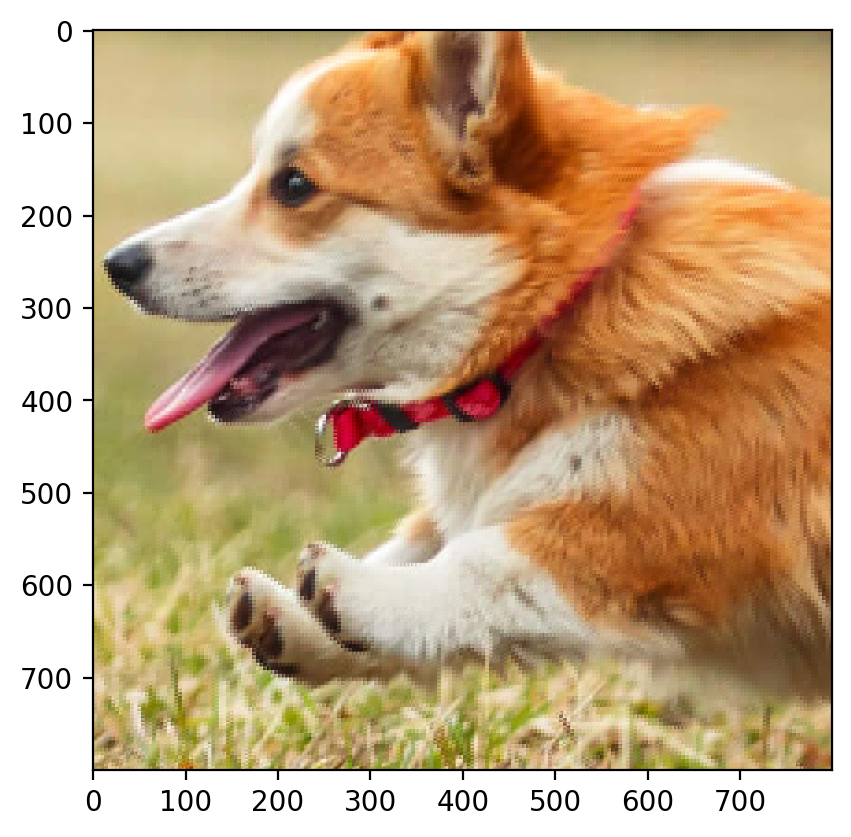

In [ ]:
upscaled_img=upscale(crop_)
plt.imshow(rearrange(torch.tensor(upscaled_img), 'c h w -> h w c').numpy())

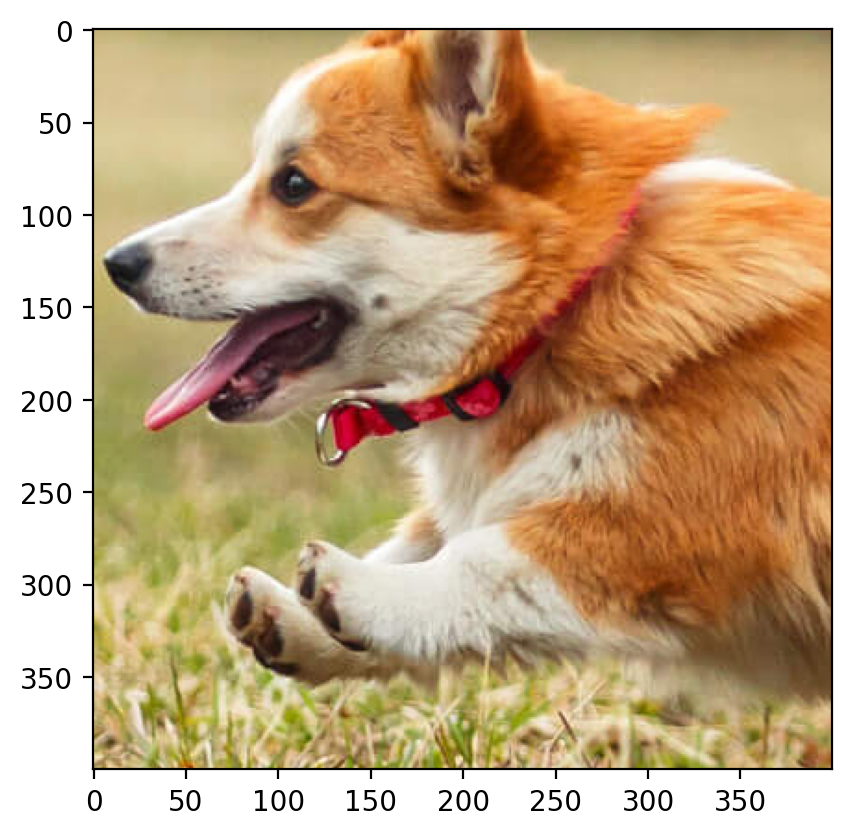

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').numpy())

In [ ]:
def plot_upscaled_and_original_image(original_img, upscaled_img, title=""):

    num_channels, height, width = original_img.shape

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])


    ax0.set_title("Original Image 400*400")
    ax0.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Upscaled Image 800*800")
    #ax1.imshow(maskedImage.reshape(200,200,3).cpu().numpy())
    ax1.imshow(rearrange(torch.tensor(upscaled_img), 'c h w -> h w c').cpu().numpy())

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

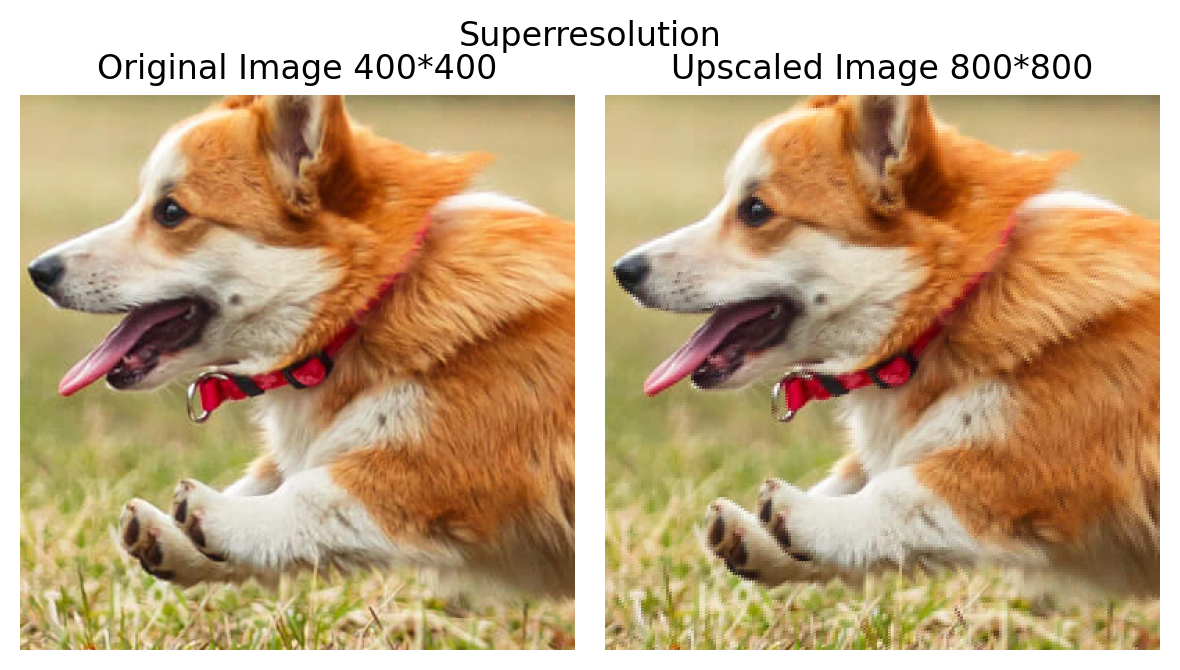

In [ ]:
plot_upscaled_and_original_image(crop, upscaled_img, "Superresolution")

#Observations:
#### Using linear regression based interpolation apporach, we increased the resolution of image by factor of 2. The dog image of size 400 * 400 that is ultimately upscaled to 800 * 800 image. The upscaled image is good but pixeleted. In order to do upscaling, entire image is dividied into 2*2 sized patches, then we trained sklearn's linear regression on 4 corner datapoints of patch and predict for intermediate points of patch

